In [1]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import Affine
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # Using Pillow for PNG
import csv
import os # For creating output directories if they don't exist

print("Libraries imported successfully.")

Libraries imported successfully.


In [4]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: E:\Hackathon\Geophy


In [5]:
# Change to a new directory (replace with your desired path)
# Use forward slashes (/) even on Windows for better cross-platform compatibility
os.chdir(r'E:\Hackathon\Geophy')

# Verify the change
print("Current directory AFTER change:", os.getcwd())

Current directory AFTER change: E:\Hackathon\Geophy


In [14]:
# --- USER INPUT REQUIRED ---
# Path to your input projected .tif file
input_raster_path = 'MA_rtp_res.tif' # e.g., r'C:\data\my_projected_map.tif' or r'/home/user/data/my_projected_map.tif'

# Directory where you want to save the output files
output_dir = r'E:\Hackathon\Geophy' # e.g., r'C:\data\output' or r'/home/user/data/output'

# Desired names for your output files
output_png_name = 'norm_MA_rtpres.png'
output_csv_name = 'norm_MA_rtpres.csv'
output_geotiff_name = 'norm_MA_rtpres.tif' # Optional: for saving the processed GeoTIFF
# --- END OF USER INPUT ---

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Construct full output paths
output_png_path = os.path.join(output_dir, output_png_name)
output_csv_path = os.path.join(output_dir, output_csv_name)
output_geotiff_path = os.path.join(output_dir, output_geotiff_name) # Full path for optional GeoTIFF

# Target resolution for resampling
target_resolution_meters = (200.0, 200.0)

print(f"Input Raster Path: {input_raster_path}")
print(f"Output Directory: {output_dir}")
print(f"Output PNG Path: {output_png_path}")
print(f"Output CSV Path: {output_csv_path}")
print(f"Output GeoTIFF Path (Optional): {output_geotiff_path}")
print(f"Target Resolution: {target_resolution_meters} meters")

# Check if input file exists
if not os.path.exists(input_raster_path):
    print(f"ERROR: Input raster file not found at '{input_raster_path}'. Please check the path.")
else:
    print("Input file found.")

Input Raster Path: MA_rtp_res.tif
Output Directory: E:\Hackathon\Geophy
Output PNG Path: E:\Hackathon\Geophy\norm_MA_rtpres.png
Output CSV Path: E:\Hackathon\Geophy\norm_MA_rtpres.csv
Output GeoTIFF Path (Optional): E:\Hackathon\Geophy\norm_MA_rtpres.tif
Target Resolution: (200.0, 200.0) meters
Input file found.


In [15]:
try:
    with rasterio.open(input_raster_path) as src:
        src_crs = src.crs
        src_transform = src.transform
        src_profile = src.profile.copy() # Get a copy of the metadata
        original_data = src.read(1) # Read the first band
        original_nodata = src.nodata

        print(f"Successfully opened: {input_raster_path}")
        print(f"Original CRS: {src_crs}")
        print(f"Original Transform (Affine):\n{src_transform}")
        print(f"Original Dimensions (Height, Width): {original_data.shape}")
        print(f"Original Data Type: {original_data.dtype}")
        print(f"Original NoData value: {original_nodata}")
except FileNotFoundError:
    print(f"ERROR: Input raster file not found at '{input_raster_path}'. Please ensure the path in Cell 2 is correct.")
except Exception as e:
    print(f"An error occurred while opening the raster: {e}")

Successfully opened: MA_rtp_res.tif
Original CRS: EPSG:32643
Original Transform (Affine):
| 200.00, 0.00, 607128.26|
| 0.00,-200.00, 1743302.09|
| 0.00, 0.00, 1.00|
Original Dimensions (Height, Width): (1115, 949)
Original Data Type: float32
Original NoData value: -3.4028234663852886e+38


In [16]:
# Ensure 'src_transform' and 'original_data' are available from the previous cell
if 'src_transform' not in locals():
    print("ERROR: Raster not loaded. Please run the previous cell successfully.")
else:
    current_resolution_x = src_transform.a
    current_resolution_y = abs(src_transform.e) # 'e' is typically negative for North-up images

    print(f"Current X-Resolution: {current_resolution_x} m")
    print(f"Current Y-Resolution: {current_resolution_y} m")

    processed_data = None
    final_transform = None
    final_height = None
    final_width = None

    # Check if resampling is needed (within a small tolerance)
    if not (np.isclose(current_resolution_x, target_resolution_meters[0]) and \
            np.isclose(current_resolution_y, target_resolution_meters[1])):
        
        print(f"Resampling to {target_resolution_meters}m resolution...")
        
        with rasterio.open(input_raster_path) as src: # Re-open for reproject function context
            # Calculate new transform and dimensions for the target resolution
            dst_affine, dst_width, dst_height = calculate_default_transform(
                src.crs, src.crs, src.width, src.height, *src.bounds,
                resolution=target_resolution_meters
            )
            
            # Create an empty array for the resampled data
            resampled_data_array = np.empty((dst_height, dst_width), dtype=original_data.dtype)

            reproject(
                source=rasterio.band(src, 1),
                destination=resampled_data_array,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_affine,
                dst_crs=src.crs,
                resampling=Resampling.bilinear # Common choice for continuous data
            )
        
        processed_data = resampled_data_array
        final_transform = dst_affine
        final_height = dst_height
        final_width = dst_width
        print("Resampling complete.")
        print(f"New Dimensions (Height, Width): ({final_height}, {final_width})")
        print(f"New Transform (Affine):\n{final_transform}")
    else:
        print(f"Raster already at approximately {target_resolution_meters}m resolution. No resampling performed.")
        processed_data = original_data
        final_transform = src_transform
        final_height = original_data.shape[0]
        final_width = original_data.shape[1]

    # At this point, 'processed_data' holds the raster values (resampled or original)
    # and 'final_transform', 'final_height', 'final_width' are set.

Current X-Resolution: 200.0 m
Current Y-Resolution: 200.0 m
Raster already at approximately (200.0, 200.0)m resolution. No resampling performed.


In [17]:
if processed_data is None:
    print("ERROR: 'processed_data' is not available. Please ensure previous cells ran correctly.")
else:
    # Convert data to float32 for operations and to handle NaNs
    # If original_nodata exists, replace those values with np.nan
    if original_nodata is not None:
        print(f"Replacing original NoData value ({original_nodata}) with NaN.")
        # Ensure processed_data is float before assigning np.nan
        if not np.issubdtype(processed_data.dtype, np.floating):
            processed_data = processed_data.astype(np.float32)
        processed_data[processed_data == original_nodata] = np.nan
    elif not np.issubdtype(processed_data.dtype, np.floating):
        # If no nodata value but data is integer, still convert to float for normalization
        print("Converting data to float32 for normalization.")
        processed_data = processed_data.astype(np.float32)
    
    print("Data prepared for normalization (handled NoData and ensured float type).")
    print(f"Data type after NoData handling: {processed_data.dtype}")

Replacing original NoData value (-3.4028234663852886e+38) with NaN.
Data prepared for normalization (handled NoData and ensured float type).
Data type after NoData handling: float32


In [18]:
if processed_data is None:
    print("ERROR: 'processed_data' is not available. Please ensure previous cells ran correctly.")
else:
    min_val = np.nanmin(processed_data) # Use nanmin to ignore NaNs
    max_val = np.nanmax(processed_data) # Use nanmax to ignore NaNs

    print(f"Min value in data (ignoring NaN): {min_val}")
    print(f"Max value in data (ignoring NaN): {max_val}")

    if np.isnan(min_val) or np.isnan(max_val): # This happens if the array is all NaNs
        normalized_data = np.full_like(processed_data, np.nan, dtype=np.float32)
        print("Data consists entirely of NaN values. Normalized data is all NaN.")
    elif max_val == min_val:
        # If all non-NaN values are the same, normalize to 0.5 (or 0, or 1, depending on preference)
        # Here, we set to 0 if it's a flat raster, but keep NaNs as NaNs.
        normalized_data = np.full_like(processed_data, 0.0, dtype=np.float32)
        normalized_data[np.isnan(processed_data)] = np.nan # Preserve NaNs
        print("Data is flat (all non-NaN values are the same). Normalized non-NaN values to 0.0.")
    else:
        normalized_data = (processed_data - min_val) / (max_val - min_val)
        print("Normalization to 0-1 complete.")
    
    # Verify normalization (optional)
    print(f"Min normalized value (ignoring NaN): {np.nanmin(normalized_data)}")
    print(f"Max normalized value (ignoring NaN): {np.nanmax(normalized_data)}")

Min value in data (ignoring NaN): -4351.29931640625
Max value in data (ignoring NaN): 17644.115234375
Normalization to 0-1 complete.
Min normalized value (ignoring NaN): 0.0
Max normalized value (ignoring NaN): 1.0


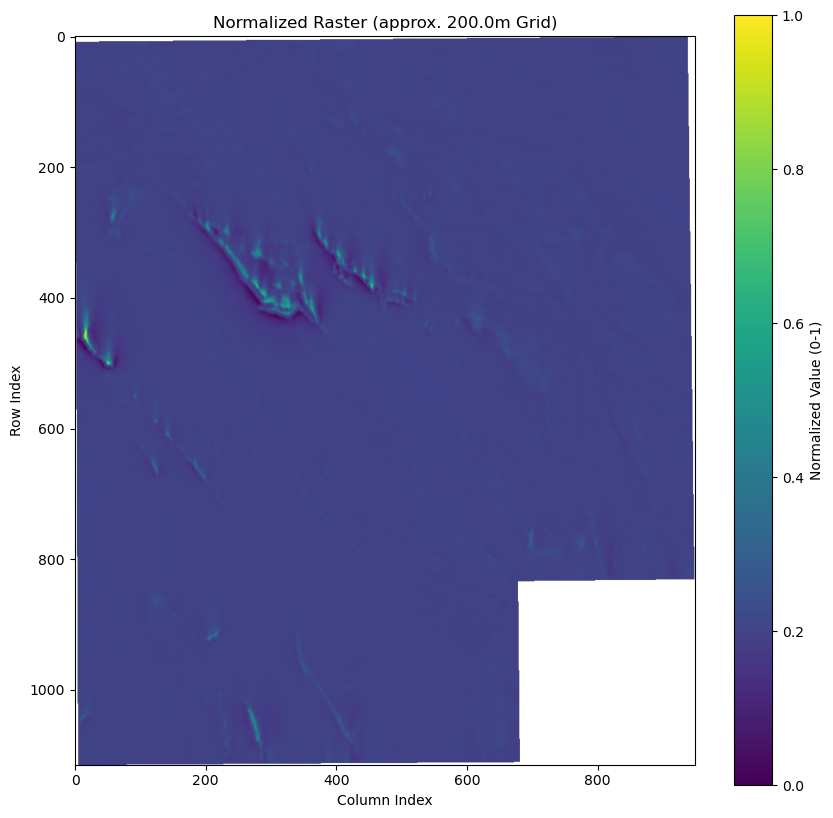

Normalized raster displayed.


In [19]:
if 'normalized_data' not in locals() or normalized_data is None:
    print("ERROR: 'normalized_data' is not available. Please ensure previous cells ran correctly.")
else:
    plt.figure(figsize=(10, 10))
    # Use a copy to avoid modifying normalized_data if plt.imshow changes it (though usually it doesn't)
    display_data = np.copy(normalized_data)
    # For display, you might want to replace NaNs with a specific color (e.g., using 'set_bad')
    # cmap = plt.cm.viridis
    # cmap.set_bad(color='lightgrey') # Example: set NaN color
    plt.imshow(display_data, cmap='viridis', vmin=0, vmax=1) # 'viridis' is a good default
    plt.colorbar(label='Normalized Value (0-1)')
    plt.title(f'Normalized Raster (approx. {target_resolution_meters[0]}m Grid)')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()
    print("Normalized raster displayed.")

In [20]:
if 'normalized_data' not in locals() or normalized_data is None:
    print("ERROR: 'normalized_data' is not available. Please ensure previous cells ran correctly.")
else:
    try:
        # Scale to 0-255 for 8-bit PNG.
        # Handle NaNs: convert them to a value (e.g., 0 for black) or use an alpha channel.
        # Here, NaNs are converted to 0 (black).
        png_array = np.nan_to_num(normalized_data, nan=0.0) # Replace NaN with 0.0
        png_array_scaled = (png_array * 255).astype(np.uint8)
        
        img = Image.fromarray(png_array_scaled, mode='L') # 'L' for grayscale
        img.save(output_png_path)
        print(f"Normalized raster saved as PNG: {output_png_path}")
        print("Note: This PNG file does not inherently contain georeferencing information.")
    except Exception as e:
        print(f"An error occurred while saving the PNG: {e}")

Normalized raster saved as PNG: E:\Hackathon\Geophy\norm_MA_rtpres.png
Note: This PNG file does not inherently contain georeferencing information.


In [21]:
# Set this to True if you want to save the processed GeoTIFF, False otherwise.
save_processed_geotiff = True 

if save_processed_geotiff:
    if 'normalized_data' not in locals() or normalized_data is None or \
       'final_transform' not in locals() or final_transform is None or \
       'src_crs' not in locals() or src_crs is None:
        print("ERROR: Required data for GeoTIFF saving (normalized_data, final_transform, src_crs) is not available.")
    else:
        try:
            # Update profile for the new (potentially resampled and normalized) data
            profile = src_profile.copy() # Start with a copy of the original profile
            profile.update({
                'dtype': 'float32', # Normalized data is float32
                'height': final_height,
                'width': final_width,
                'transform': final_transform, # Use the transform of the processed data
                'crs': src_crs, # CRS should be the same as the input projected raster
                'count': 1,     # Assuming single band output
                'nodata': np.nan # Explicitly set nodata to NaN for float data
            })

            with rasterio.open(output_geotiff_path, 'w', **profile) as dst_geotiff:
                dst_geotiff.write(normalized_data.astype(np.float32), 1) # Write the normalized data
            print(f"Processed (resampled and normalized) GeoTIFF saved to: {output_geotiff_path}")
        except Exception as e:
            print(f"An error occurred while saving the processed GeoTIFF: {e}")
else:
    print("Skipping save of processed GeoTIFF as 'save_processed_geotiff' is False.")

Processed (resampled and normalized) GeoTIFF saved to: E:\Hackathon\Geophy\norm_MA_rtpres.tif
